In [1]:
""" github 연동 """
# !git clone https://github.com/ku-sungsukim/2025-LGElec-Day4.git ### colab 사용시

' github 연동 '

## **0. 필요 패키지 불러오기**

In [2]:
""" 필요 패키지 설치 """
# !pip install pmdarima

' 필요 패키지 설치 '

In [3]:
""" 데이터 전처리 관련 패키지 """
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


""" 기계학습 모델 구축 및 평가 패키지 """
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).reshape(-1), np.array(y_pred).reshape(-1)
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


""" 데이터 시각화 패키지 """
import matplotlib.pyplot as plt
%matplotlib inline


""" 경고 숨기기 """
import warnings
warnings.filterwarnings(action='ignore')

c:\Users\korea\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## **1. 데이터 불러오기 및 전처리**
 - 분석데이터: 위스콘신주 취업건수 데이터 (월별 고용자수 예측)

#### **1-1. 데이터 개요 파악 및 전처리**

In [4]:
""" 데이터 불러오기 """

"""
데이터 개요
 - 관측치 개수: 178개
 - 변수 개수: 2개
 
주요 변수 정보
 - month: 일자
 - employment: 고용자수
"""

"""
Q1. 데이터를 pandas 패키지를 활용하여 불러올 것
"""

data = pd.read_csv('data/Employment.csv') ### 로컬 사용시
# data = pd.read_csv('/content/2025-LGElec-Day4/data/Employment.csv') ### colab 사용시

data

,month,employment
0,1961-01-01,239.6
1,1961-02-01,236.4
2,1961-03-01,236.8
3,1961-04-01,241.5
4,1961-05-01,243.7
...,...,...
173,1975-06-01,394.6
174,1975-07-01,394.0
175,1975-08-01,397.0
176,1975-09-01,397.2


In [5]:
""" 간단한 전처리 """

"""
Q1. month변수의 데이터 타입을 datetime으로 변경
Q2. month변수를 index로 지정
"""

data['month'] = pd.to_datetime(data['month']) ### datetime 형변환
data = data.set_index('month') ### month 변수를 index로 지정

#### **1-2. 탐색적 데이터 분석**

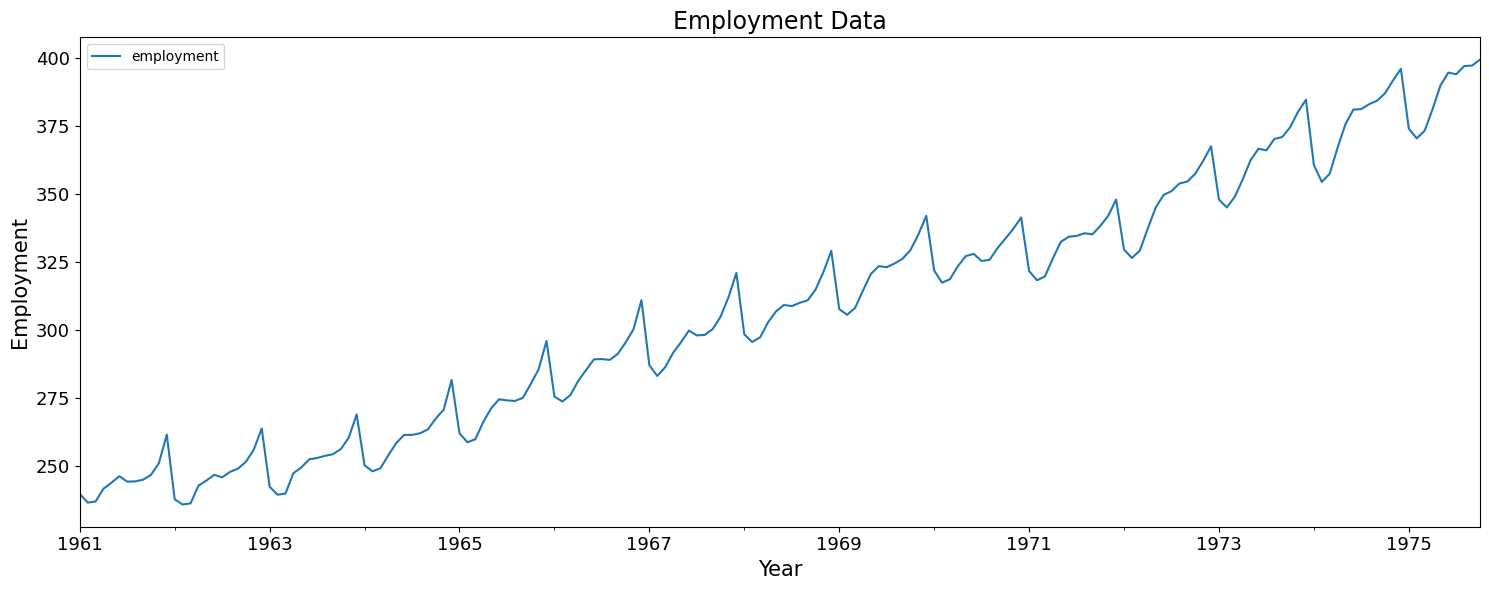

In [6]:
""" 탐색적 데이터 분석: 데이터 시각화를 통해 시계열 형태 확인 """

"""
Q1. 시간에 따른 employment 변수 흐름 시각화
 - x축 및 y축 눈금의 폰트크기 모두 13으로 지정
 - Figure 제목은 Employment Data, 폰트크기는 17로 지정
 - x축 및 y축 레이블의 폰트크기는 모두 15로 지정하며, 레이블 이름은 각각 Year와 Employment로 지정
"""

data.plot(figsize=(15, 6)) ### 시각화

plt.xticks(fontsize=13) ### x축 눈금 크기 지정
plt.yticks(fontsize=13) ### y축 눈금 크기 지정

plt.title('Employment Data', fontsize=17) ### title 지정
plt.xlabel('Year', fontsize=15) ### x축 레이블 지정
plt.ylabel('Employment', fontsize=15) ### y축 레이블 지정
plt.tight_layout()
plt.show()

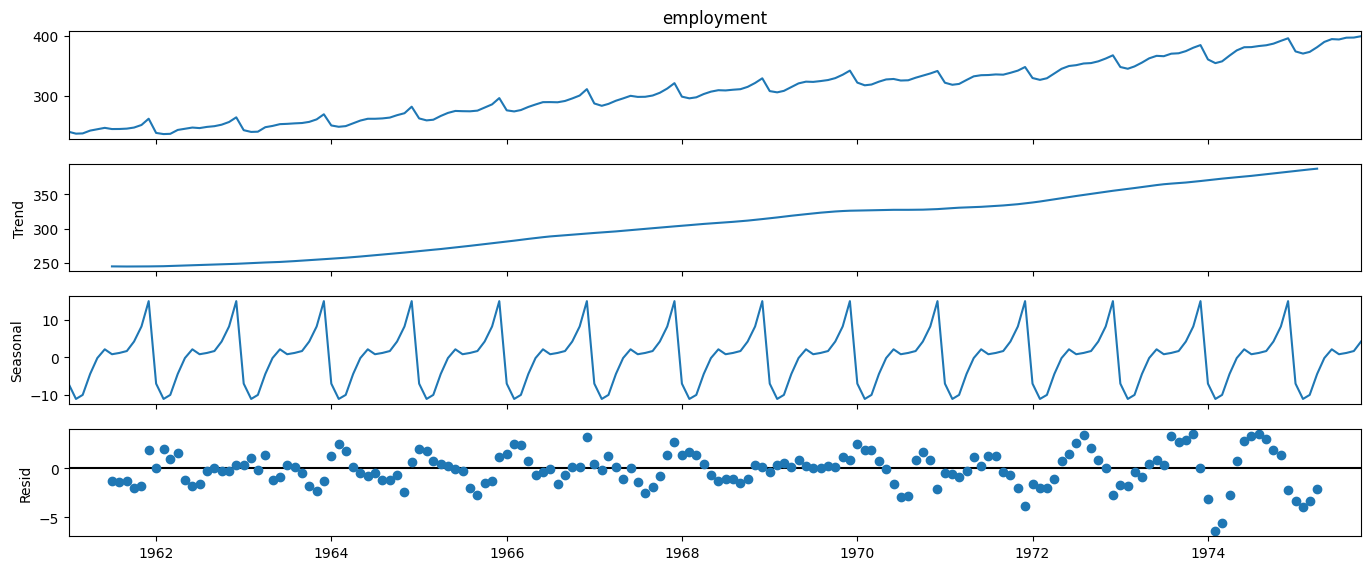

In [7]:
""" 탐색적 데이터 분석: 시계열 분해 """

"""
Q1. 시계열 데이터를 [추세(Trend)변동 + 계절(Seasonal)변동 + 우연(Random)변동]으로 분해할 것
"""

decomposition = sm.tsa.seasonal_decompose(data['employment'],  model='additive') ### decomposition 정의

fig = decomposition.plot() ### 시계열 분해 그림 시각화
fig.set_size_inches(15, 6) ### figure 크기 정의
plt.show()

#### **1-3. 학습/평가 데이터 분할**

In [8]:
""" 학습/평가데이터 분할 """

"""
Q1. 학습데이터와 평가데이터를 8:2로 구분할 것
 - 이때, sklearn의 train_test_split함수를 활용할 것
"""

train, test = train_test_split(data, test_size=0.2, shuffle=False)
train.shape, test.shape

((142, 1), (36, 1))

## **2. 모델링**

#### **2-1. ARIMA**

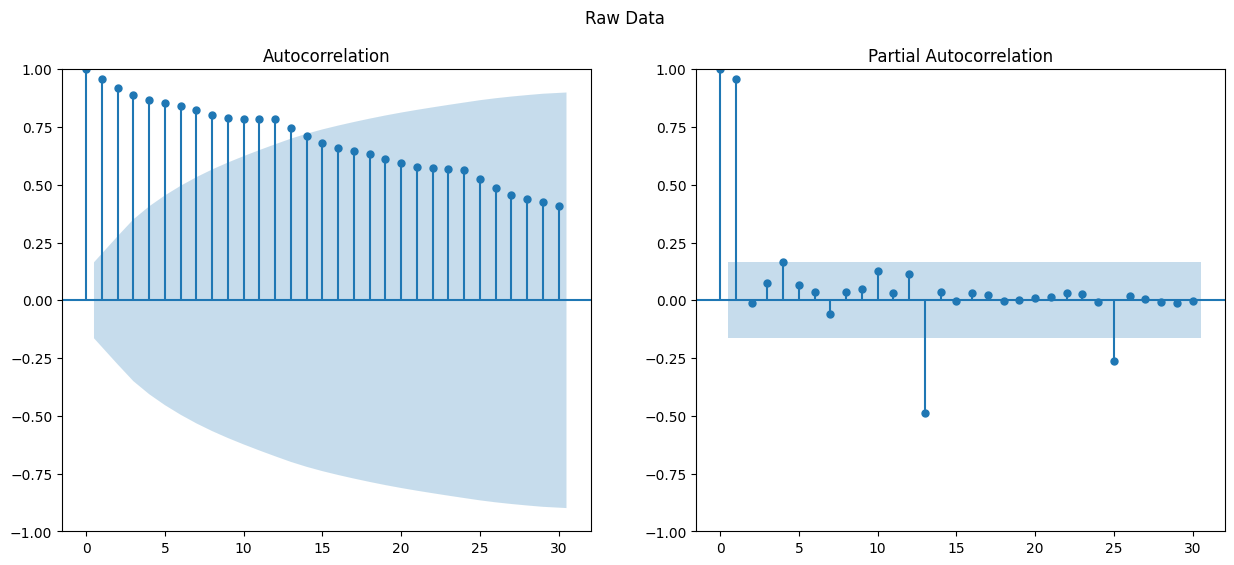

In [9]:
""" 정상성 확인 """

"""
Q1. ACF 및 PACF 그래프를 시각화
 - 두 그래프 모두 lag는 30으로 그릴 것
"""

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Raw Data') ### Figure 제목 지정
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=30, ax=ax[0]) ### ACF 시각화
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=30, ax=ax[1]); ### PACF 시각화

In [10]:
""" 차분수행 """

"""
Q1. employment변수에 대하여 1차차분 수행
 - 이때, 발생하는 결측행들도 함께 제거
"""

diff_train = train['employment'].diff() ### 차분 수행
diff_train = diff_train.dropna() ### 결측행 제거

print('####### Raw Data #######')
print(train)
print('### Differenced Data ###')
print(diff_train)

####### Raw Data #######
            employment
month                 
1961-01-01       239.6
1961-02-01       236.4
1961-03-01       236.8
1961-04-01       241.5
1961-05-01       243.7
...                ...
1972-06-01       349.6
1972-07-01       351.0
1972-08-01       353.8
1972-09-01       354.5
1972-10-01       357.4

[142 rows x 1 columns]
### Differenced Data ###
month
1961-02-01   -3.2
1961-03-01    0.4
1961-04-01    4.7
1961-05-01    2.2
1961-06-01    2.4
             ... 
1972-06-01    4.7
1972-07-01    1.4
1972-08-01    2.8
1972-09-01    0.7
1972-10-01    2.9
Name: employment, Length: 141, dtype: float64


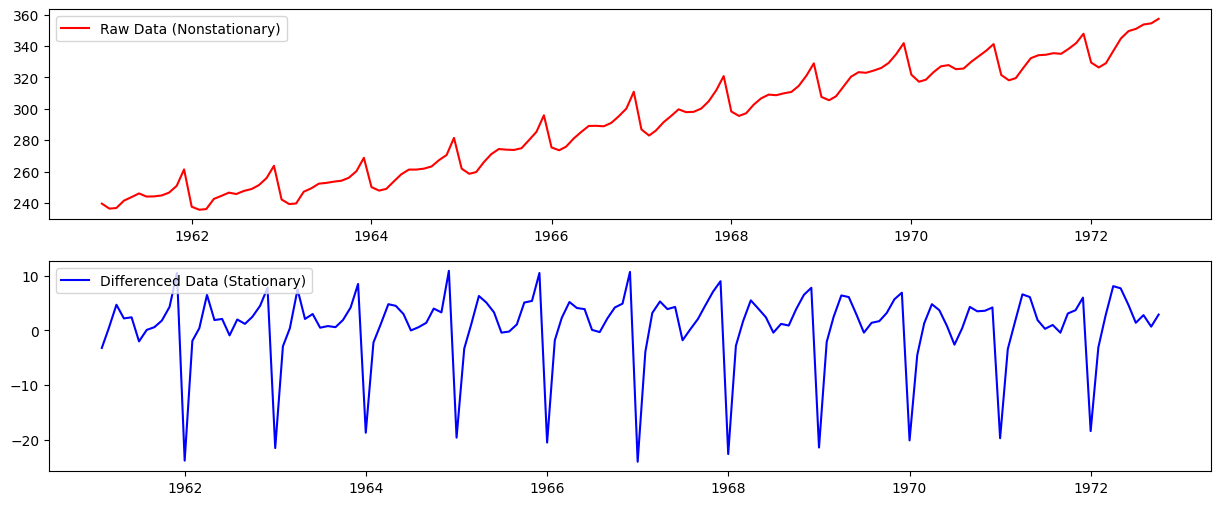

In [11]:
""" 그래프로 차분 전/후 비교 """

"""
Q1. 1차차분 전/후 비교 그래프 시각화
 - 색깔은 각각 red, blue로 지정
 - 범례를 설정할 것 (차분 전: Raw Data (Nonstationary) // 차분 후: Differenced Data (Stationary))
   * 위치는 좌상단
"""

plt.figure(figsize=(15, 6))

plt.subplot(211)
plt.plot(train['employment'], 'red') ### 차분 전 시각화
plt.legend(['Raw Data (Nonstationary)'], loc='upper left') ### 차분 전 범례

plt.subplot(212)
plt.plot(diff_train, 'blue') ### 차분 후 시각화
plt.legend(['Differenced Data (Stationary)'], loc='upper left') ### 차분 후 범례

plt.show()

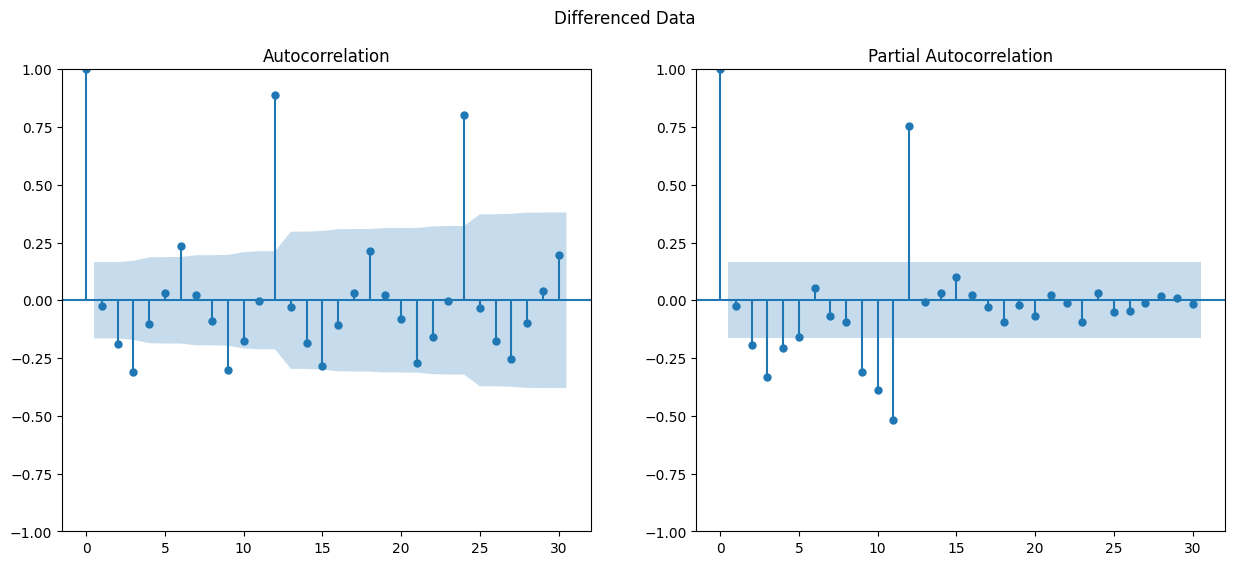

In [12]:
""" 차분 후 정상성 파악 """

"""
Q1. 차분 후 데이터에 대하여 ACF 및 PACF 그래프를 시각화
 - 두 그래프 모두 lag는 30으로 그릴 것
"""

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Differenced Data') ### Figure 제목 지정
sm.graphics.tsa.plot_acf(diff_train.values.squeeze(), lags=30, ax=ax[0]) ### ACF 시각화
sm.graphics.tsa.plot_pacf(diff_train.values.squeeze(), lags=30, ax=ax[1]); ### PACF 시각화

In [13]:
""" ARIMA 파라미터 탐색 범위 설정 """

"""
Q1. itertools 패키지를 활용하여 ARIMA (p, d, q)의 파라미터 범위를 지정할 것
 - p: 0, 1, 2
 - d: 1
 - q: 0, 1, 2
"""

p = range(0, 3) ### p의 범위
d = range(1, 2) ### d의 범위
q = range(0, 3) ### q의 범위
pdq = list(itertools.product(p, d, q)) ### 모든 Combination 고려

In [14]:
""" ARIMA 파라미터 탐색 """

"""
Q1. AIC를 기준으로 최적 ARIMA 파라미터 식별
 - AIC는 작을수록 좋은 지표
 - AIC는 소수 둘째자리까지 반올림
"""

aic=[]
for i in pdq:
    model = ARIMA(train.values, order=(i)) ### 모델 정의
    ARIMA_model_fit = model.fit() ### 모델 피팅
    print(f'ARIMA: {i} >> AIC : {round(ARIMA_model_fit.aic, 2)}')
    aic.append(round(ARIMA_model_fit.aic, 2))

ARIMA: (0, 1, 0) >> AIC : 955.54
ARIMA: (0, 1, 1) >> AIC : 957.52
ARIMA: (0, 1, 2) >> AIC : 949.99
ARIMA: (1, 1, 0) >> AIC : 957.53
ARIMA: (1, 1, 1) >> AIC : 949.94
ARIMA: (1, 1, 2) >> AIC : 947.21
ARIMA: (2, 1, 0) >> AIC : 955.22
ARIMA: (2, 1, 1) >> AIC : 944.02
ARIMA: (2, 1, 2) >> AIC : 908.43


In [15]:
""" 최소 AIC를 만족하는 (p, d, q) 식별 """

"""
Q1. 모든 parameter 범위 중, 최소 AIC를 만족하는 (p, d, q) 찾기
"""

ARIMA_optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)] 
ARIMA_optimal_pdq = ARIMA_optimal[0][0]
ARIMA_optimal_pdq

(2, 1, 2)

In [16]:
""" 최적 (p, d, q)로 ARIMA 학습 """

"""
Q1. 위에서 도출한 최적 (p, d, q)로 ARIMA 모델 학습
"""

ARIMA_model_opt = ARIMA(train.values, order=ARIMA_optimal_pdq) 
ARIMA_model_opt_fit = ARIMA_model_opt.fit()

ARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  142
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -449.213
Date:                Mon, 03 Mar 2025   AIC                            908.425
Time:                        15:40:16   BIC                            923.169
Sample:                             0   HQIC                           914.417
                                - 142                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9957      0.021     48.160      0.000       0.955       1.036
ar.L2         -0.9828      0.028    -34.860      0.000      -1.038      -0.928
ma.L1         -1.1195      2.377     -0.471      0.638      -5.779       3.540
ma.L2          0.9992      4.259      0.235      0.814      -7.347       9.346
sigma2        32.5314    138.460      0.235      0.814    -238.845     303.908
===================================================================================
Ljung-Box (L1) (Q):                   5.70   Jarque-Bera (JB):               127.34
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -1.61
Prob(H) (two-sided):                  0.92   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
""" ARIMA 모델 Test 기간 예측 """

"""
Q1. ARIMA 모델을 활용하여 Test기간만큼 예측
"""

ARIMA_prediction = ARIMA_model_opt_fit.get_forecast(len(test)) ### 예측모형 수립
ARIMA_test_pred = ARIMA_prediction.predicted_mean ### 예측값 산출
ARIMA_test_pred

array([362.42377823, 362.12100256, 356.88213364, 351.96360909,
       352.21526825, 357.29979869, 362.11489342, 361.91193916,
       356.97755353, 352.26408336, 352.42065689, 357.20898597,
       361.82261787, 361.71018564, 357.0639278 , 352.54836713,
       352.61881551, 357.12688681, 361.54612373, 361.51558115,
       357.14190995, 352.81726911, 352.80990707, 357.05286865,
       361.28462102, 361.32796087, 357.21211223, 353.07156093,
       352.99409809, 356.98633893, 361.03735611, 361.14715679,
       357.27510805, 353.31197861, 353.17155784, 356.92674283])

In [18]:
""" ARIMA 모델 평가 """

"""
Q1. ARIMA 모델의 성능 평가
 - MSE, RMSE, MAE, MAPE, R2score를 모두 산출할 것
"""

print(f'MSE: {np.round(mean_squared_error(test, ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, ARIMA_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')

MSE: 523.5
RMSE: 22.88
MAE: 18.83
MAPE: 4.91
R2 score: -1.33


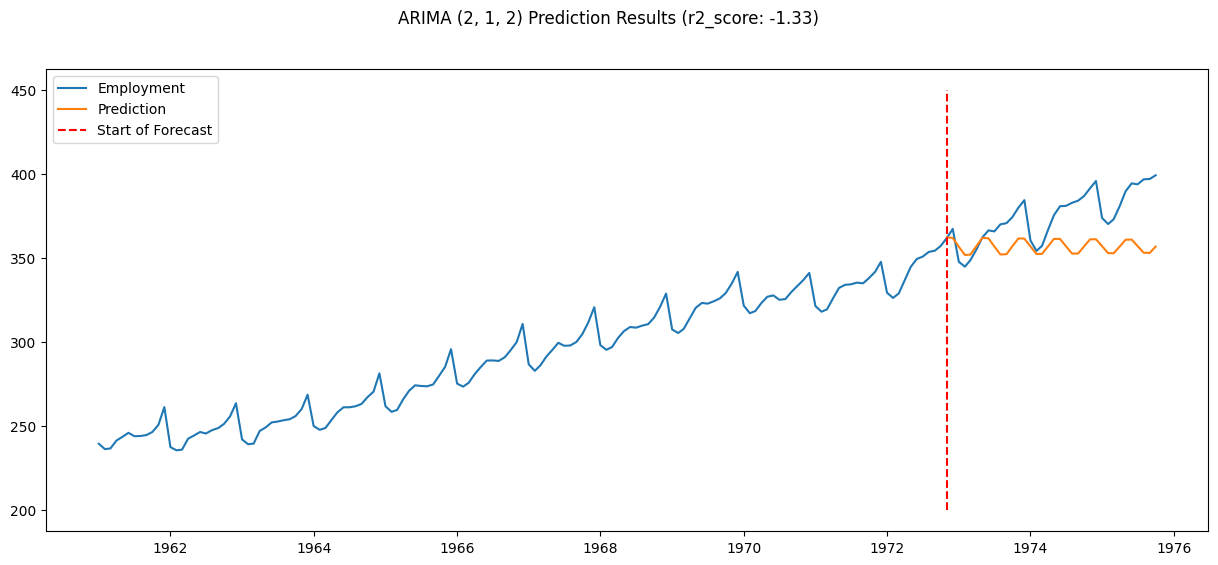

In [19]:
""" ARIMA 예측 결과 시각화 """

"""
Q1. 기존 값과 ARIMA의 예측값을 함께 시각화
 - 기존값 및 예측값의 레이블: Employment, Prediction
 - train/test가 나뉘는 시점을 빨간 수직 점선으로 표시할 것 (레이블: Start of Forecast)
   * 수직선 y범위: 200~450 / train 및 test 분기점: 1972-11-01
 - 실제값 / 예측값 / train, test 분기점에 대해 범례를 설정할 것 (위치: 좌상단)
"""

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(data.index, data.values, label = 'Employment') 
ax.plot(test.index, ARIMA_test_pred, label = 'Prediction') 

ax.vlines(datetime.datetime.strptime('1972-11-01','%Y-%m-%d'), ymin=200, ymax=450, linestyle='--', color='r', label='Start of Forecast') 
ax.legend(loc='upper left') 
plt.suptitle(f'ARIMA {ARIMA_optimal_pdq} Prediction Results (r2_score: {np.round(r2_score(test, ARIMA_test_pred), 2)})') 
plt.show()

#### **2-2. SARIMA**

In [20]:
""" SARIMA 파라미터 탐색 범위 설정 """

"""
Q1. itertools 패키지를 활용하여 SARIMA (p, d, q) 및 (P, D, Q)의 파라미터 범위를 지정할 것
 - p: 0, 1, 2
 - d: 1
 - q: 0, 1, 2
 - P: 0, 1, 2
 - D: 1
 - Q: 0, 1, 2
 - s: 12(고정)
"""

p = range(0, 3) ### p, P범위 지정
d = range(1, 2) ### d, D범위 지정
q = range(0, 3) ### q, Q범위 지정
pdq = list(itertools.product(p, d, q)) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] ### (P, D, Q) Combination 설정

In [21]:
""" SARIMA 파라미터 탐색 """

"""
Q1. AIC를 기준으로 최적 SARIMA 파라미터 식별 (AIC는 소수 둘째자리에서 반올림)
 - AIC는 작을수록 좋은 지표
"""

aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train.values, order=(i), seasonal_order = (j)) 
            model_fit = model.fit() 
            print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic, 2)}')
            aic.append(round(model_fit.aic, 2))
            params.append((i, j))  
        except:
            continue

SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 456.16
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 449.2
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 446.66
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 451.86
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 446.51
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 448.32
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 450.51
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 448.31
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 450.04
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 454.94
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 448.88
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 446.09
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 451.34
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 445.97
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 447.71
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 450.1
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 447.68
SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : 449.34
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 456.9
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 450.88
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 448.06
SARIMA: (0, 1, 2

In [22]:
""" 최소 AIC를 만족하는 (p, d, q) 식별 """

"""
Q1. 모든 parameter 범위 중, 최소 AIC를 만족하는 (p, d, q) 및 (P, D, Q) 찾기
"""

SARIMA_optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)] 

SARIMA_optimal_pdq = SARIMA_optimal[0][0][0] 
SARIMA_optimal_seasonal_pdq = SARIMA_optimal[0][0][1] 
SARIMA_optimal_AIC = SARIMA_optimal[0][1] 
print(f'Optimal (p, d, q): {SARIMA_optimal_pdq}')
print(f'Optimal Seasonal (P, D, Q): {SARIMA_optimal_seasonal_pdq}')
print(f'Optimal AIC: {SARIMA_optimal_AIC}')

Optimal (p, d, q): (1, 1, 0)
Optimal Seasonal (P, D, Q): (1, 1, 1, 12)
Optimal AIC: 445.83


In [23]:
""" 최적 파라미터로 SARIMA 학습 """

"""
Q1. 위에서 도출한 최적 (p, d, q) 및 (P, D, Q)로 SARIMA 모델 학습
"""

SARIMA_model_opt = SARIMAX(train.values, order=SARIMA_optimal_pdq, seasonal_order=SARIMA_optimal_seasonal_pdq) 
SARIMA_model_opt_fit = SARIMA_model_opt.fit()

SARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -218.913
Date:                              Mon, 03 Mar 2025   AIC                            445.826
Time:                                      15:40:41   BIC                            457.265
Sample:                                           0   HQIC                           450.474
                                              - 142                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1439      0.090      1.591      0.112      -0.033       0.321
ar.S.L12       0.4458      0.228      1.954      0.051      -0.001       0.893
ma.S.L12      -0.8001      0.207     -3.858      0.000      -1.207      -0.394
sigma2         1.6863      0.215      7.837      0.000       1.265       2.108
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.38
Prob(Q):                              0.78   Prob(JB):                         0.11
Heteroskedasticity (H):               1.51   Skew:                            -0.39
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
""" SARIMA 모델 Test 기간 예측 """

"""
Q1. ARIMA 모델을 활용하여 Test기간만큼 예측
"""

SARIMA_prediction = SARIMA_model_opt_fit.get_forecast(len(test)) ### SARIMA 예측모형 수립
SARIMA_test_pred = SARIMA_prediction.predicted_mean ### 예측값 산출
SARIMA_test_pred

array([361.52438708, 368.19567422, 348.84992541, 345.7408167 ,
       348.05413346, 355.33145198, 361.89096154, 365.80176876,
       366.43905093, 368.49791378, 369.48159602, 372.58499995,
       376.94069371, 383.91732082, 364.15079832, 361.03775411,
       363.17869299, 370.08923601, 376.14027831, 379.69923783,
       379.99647566, 381.72491553, 382.83507252, 386.02916051,
       390.4879783 , 397.60073588, 377.64661881, 374.53182002,
       376.59590725, 383.34292986, 389.16728096, 392.56937537,
       392.71501039, 394.29613698, 395.46268051, 398.69719841])

In [25]:
""" SARIMA 모델 평가 """

"""
Q1. SARIMA 모델의 성능 평가
 - MSE, RMSE, MAE, MAPE, R2score를 모두 산출할 것
"""

print(f'MSE: {np.round(mean_squared_error(test, SARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, SARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA_test_pred), 2)}')

MSE: 5.54
RMSE: 2.35
MAE: 1.82
MAPE: 0.49
R2 score: 0.98


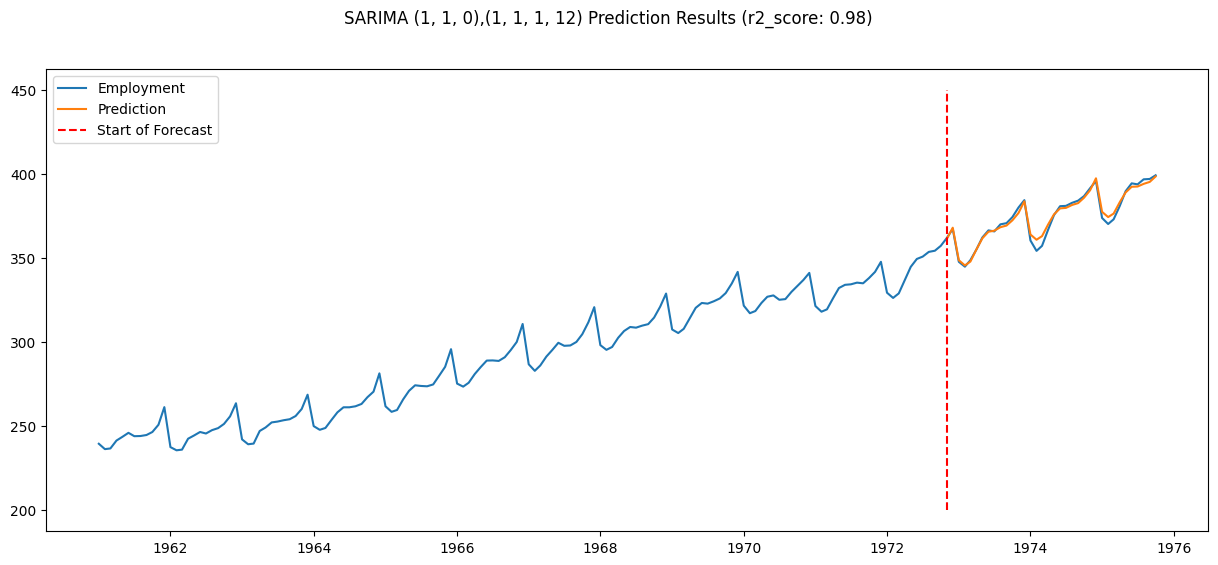

In [26]:
""" SARIMA 예측 결과 시각화 """

"""
Q1. 기존 값과 SARIMA의 예측값을 함께 시각화
 - 기존값 및 예측값의 레이블: Employment, Prediction
 - train/test가 나뉘는 시점을 빨간 수직 점선으로 표시할 것 (레이블: Start of Forecast)
   * 수직선 y범위: 200~450 / train 및 test 분기점: 1972-11-01
 - 실제값 / 예측값 / train 및 test분기점에 대해 범례를 설정할 것 (위치: 좌상단)
"""

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(data.index, data.values, label = 'Employment') 
ax.plot(test.index, SARIMA_test_pred, label = 'Prediction') 

ax.vlines(datetime.datetime.strptime('1972-11-01','%Y-%m-%d'), ymin=200, ymax=450, linestyle='--', color='r', label='Start of Forecast') 
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {SARIMA_optimal_pdq},{SARIMA_optimal_seasonal_pdq} Prediction Results (r2_score: {np.round(r2_score(test, SARIMA_test_pred), 2)})') 
plt.show()

#### **2.3 AUTO ARIMA & SARIMA (Simple Version)**

In [27]:
""" Auto ARIMA 또는 SARIMA 모델링 """

"""
Q1. auto_arima 패키지를 활용하여 SARIMA 모델을 적합할 것
 - p: 0, 1, 2
 - d: 1
 - q: 0, 1, 2
 - P: 0, 1, 2
 - D: 1
 - Q: 0, 1, 2
 - s: 12(고정)
"""

SARIMA2 = auto_arima(y=train, 
                     start_p=0, start_q=0, max_p=2, max_q=2, d=1, 
                     seasonal=True, 
                     start_P=0, start_Q=0, max_P=2, max_Q=2, D=1, m=12, 
                     trace=True,
                     error_action='ignore',  
                     suppress_warnings=True)

SARIMA2.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=456.155, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=451.312, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=448.883, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=454.937, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=445.972, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=451.339, Time=0.05 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=447.681, Time=0.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=447.712, Time=0.29 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=446.092, Time=0.18 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=450.096, Time=0.05 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=449.344, Time=0.48 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=446.512, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=447.159, Time=0.23 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=447.890, Time=0.14 sec
 ARIMA(1,1,0)(1,1,1)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  142
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -218.509
Date:                              Mon, 03 Mar 2025   AIC                            445.019
Time:                                      15:40:50   BIC                            456.458
Sample:                                  01-01-1961   HQIC                           449.667
                                       - 10-01-1972                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0542      0.035      1.527      0.127      -0.015       0.124
ar.S.L12       0.4841      0.226      2.139      0.032       0.041       0.928
ma.S.L12      -0.8799      0.244     -3.606      0.000      -1.358      -0.402
sigma2         1.6367      0.226      7.235      0.000       1.193       2.080
===================================================================================
Ljung-Box (L1) (Q):                   1.91   Jarque-Bera (JB):                 7.21
Prob(Q):                              0.17   Prob(JB):                         0.03
Heteroskedasticity (H):               1.90   Skew:                            -0.50
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
""" SARIMA2 모델 Test기간 예측 """

"""
Q1. auto_arima 패키지로 적합된 SARIMA 모델을 활용하여 Test기간만큼 예측
"""

SARIMA2_test_pred = SARIMA2.predict(len(test))
SARIMA2_test_pred 

1972-11-01    361.906778
1972-12-01    369.171968
1973-01-01    349.977009
1973-02-01    347.238471
1973-03-01    349.793154
1973-04-01    357.299988
1973-05-01    363.939854
1973-06-01    368.156078
1973-07-01    369.038716
1973-08-01    371.332049
1973-09-01    372.646568
1973-10-01    376.068082
1973-11-01    381.019624
1973-12-01    388.951494
1974-01-01    369.425896
1974-02-01    366.916543
1974-03-01    369.455079
1974-04-01    376.728962
1974-05-01    382.909818
1974-06-01    386.946047
1974-07-01    387.632430
1974-08-01    389.734687
1974-09-01    391.400895
1974-10-01    395.129077
1974-11-01    400.350129
1974-12-01    408.658941
1975-01-01    389.027481
1975-02-01    386.683279
1975-03-01    389.268199
1975-04-01    396.483511
1975-05-01    402.496361
1975-06-01    406.499656
1975-07-01    407.145234
1975-08-01    409.209191
1975-09-01    411.099854
1975-10-01    415.030694
Freq: MS, dtype: float64

In [29]:
""" SARIMA 모델 평가 """

"""
Q1. SARIMA 모델의 성능 평가
 - MSE, RMSE, MAE, MAPE, R2score를 모두 산출할 것
"""

print(f'MSE: {np.round(mean_squared_error(test, SARIMA2_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA2_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA2_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA2_test_pred), 2)}')

MSE: 86.2
RMSE: 9.28
MAE: 7.58
MAPE: 4.91
R2 score: 0.62


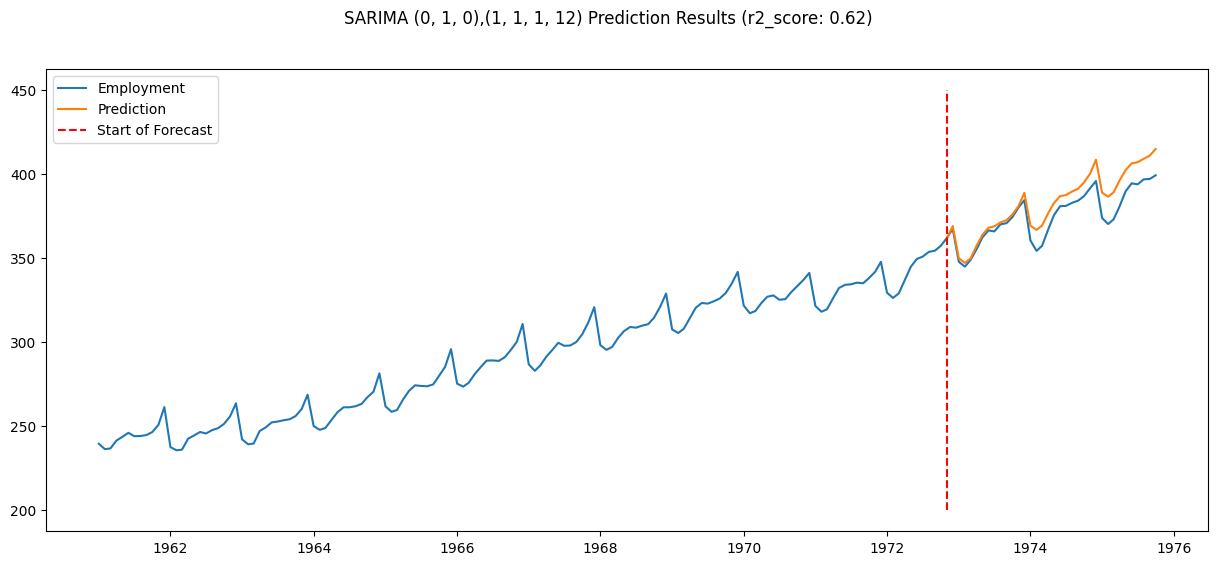

In [30]:
""" SARIMA 예측 결과 시각화 """

"""
Q1. 기존 값과 SARIMA의 예측값을 함께 시각화
 - 기존값 및 예측값의 레이블: Employment, Prediction
 - train/test가 나뉘는 시점을 빨간 수직 점선으로 표시할 것 (레이블: Start of Forecast)
   * 수직선 y범위: 200~450 / train 및 test 분기점: 1972-11-01
 - 실제값 / 예측값 / train 및 test 분기점에 대해 범례를 설정할 것 (위치: 좌상단)
"""

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(data.index, data.values, label = 'Employment') 
ax.plot(test.index, SARIMA2_test_pred, label = 'Prediction') 

ax.vlines(datetime.datetime.strptime('1972-11-01','%Y-%m-%d'), ymin=200, ymax=450, linestyle='--', color='r', label='Start of Forecast') 
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {SARIMA2.order},{SARIMA2.seasonal_order} Prediction Results (r2_score: {np.round(r2_score(test, SARIMA2_test_pred), 2)})') 
plt.show()

#### **2-4. Prophet**

In [31]:
""" Prophet 모델링을 위한 간단한 전처리 """

"""
Q1. train 및 test 데이터 모두 index를 0, 1, 2... 등 원래 index로 변경 & 기존 Timestep Index는 변수로 변경
Q2. timestep, employment 변수명을 각각 ds, y로 변경
"""

train_prophet = train.reset_index() 
train_prophet.columns = ['ds', 'y']

test_prophet = test.reset_index() 
test_prophet.columns = ['ds', 'y'] 
train_prophet.head()

,ds,y
0,1961-01-01,239.6
1,1961-02-01,236.4
2,1961-03-01,236.8
3,1961-04-01,241.5
4,1961-05-01,243.7


In [32]:
""" Prophet 모델 적합 """

"""
Q1. Prophet 모델을 학습
"""

Prophet_model = Prophet() 
Prophet_model.fit(train_prophet) 

15:40:50 - cmdstanpy - INFO - Chain [1] start processing
15:40:50 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
""" Prophet Test 기간 예측 """

"""
Q1. Prophet 모델을 Test 기간만큼 예측 한 후, 예측값 확인
"""

Prophet_test_data_index = test_prophet[['ds']]  
Prophet_test_pred = Prophet_model.predict(Prophet_test_data_index)
Prophet_test_pred = Prophet_test_pred['yhat'].values
Prophet_test_pred

array([354.069559  , 363.76587889, 343.17834324, 340.54712989,
       341.40494697, 347.40497434, 351.95059898, 354.82648146,
       354.32442817, 355.17724106, 356.47652278, 359.94548715,
       363.75700719, 372.70538473, 351.97900505, 349.1863026 ,
       350.71300001, 356.77992336, 360.8927924 , 363.78543326,
       363.24471664, 364.01068772, 365.51169533, 368.89581083,
       373.44304334, 381.62407834, 360.77659664, 357.83410789,
       360.03236954, 366.15111166, 369.82623489, 372.73954149,
       372.16364601, 372.847814  , 374.5532988 , 377.8557583 ])

In [34]:
""" Prophet 평가 """

"""
Q1. Prophet 모델의 성능 평가
 - MSE, RMSE, MAE, MAPE, R2score를 모두 산출할 것
"""

print(f'MSE: {np.round(mean_squared_error(test, Prophet_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test, Prophet_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, Prophet_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, Prophet_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, Prophet_test_pred), 2)}')

MSE: 222.17
RMSE: 14.91
MAE: 13.83
MAPE: 3.64
R2 score: 0.01


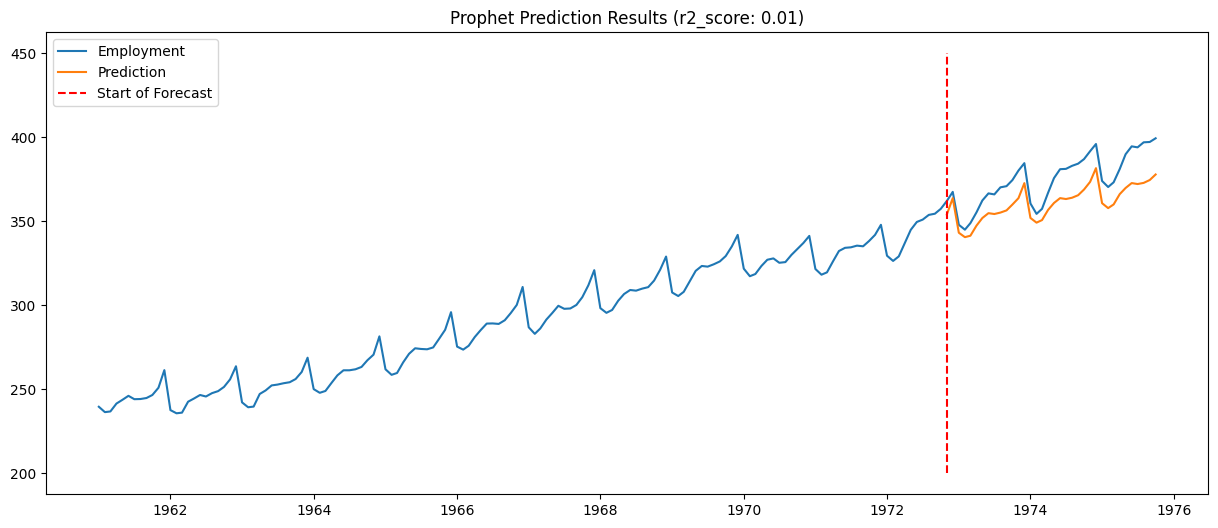

In [35]:
""" Prophet 시각화 """

"""
Q1. 기존 값과 Prohphet의 예측값을 함께 시각화
 - 기존값 및 예측값의 레이블: Employment, Prediction
 - train/test가 나뉘는 시점을 빨간 수직 점선으로 표시할 것 (레이블: Start of Forecast)
   * 수직선 y범위: 200~450 / train 및 test 분기점: 1972-11-01
 - 실제값 / 예측값 / train 및 test 분기점에 대해 범례를 설정할 것 (위치: 좌상단)
"""

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(data.index, data.values, label = 'Employment') 
ax.plot(test.index, Prophet_test_pred, label = 'Prediction') 

ax.vlines(datetime.datetime.strptime('1972-11-01','%Y-%m-%d'), ymin=200, ymax=450, linestyle='--', color='r', label='Start of Forecast') 
ax.legend(loc='upper left') 
plt.title(f'Prophet Prediction Results (r2_score: {np.round(r2_score(test, Prophet_test_pred), 2)})')
plt.show()

# **EOD**